![](https://media.sproutsocial.com/uploads/2019/03/sentiment-analysis.svg "credit: https://sproutsocial.com/insights/social-media-sentiment-analysis/")


# Introduction

The objective of this project is to perform sentiment analysis (only positive and negative) on an imbalanced hotel review dataset.

This project covers:
- TF-IDF
- count features
- logistic regression
- naive bayes
- svm
- xgboost
- grid search
- word vectors (Universal Sentence Encoder model from Tensorflow HUB)
- LSTM

The final LSTM model achieved an accuracy of ~81% in Test Dataset (75:25 split)

## Dataset Source
* [Kaggle Dataset URL - 515K Hotel Reviews Data in Europe](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe)

## Text Embedding Model
* [universal-sentence-encoder-multilingual-large-v3](https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3)


NB: This project also serves as my assignments for the course below -

* [IBM Deep Learning and Reinforcement Learning](https://www.coursera.org/learn/deep-learning-reinforcement-learning)

# Libraires & Configuration

### Check GPU

In [ ]:
!nvidia-smi

Tue Jan  4 11:28:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Libraries 

In [ ]:
%%capture
!pip install tensorflow_text
!pip install tqdm

In [ ]:
import os 

# session crash issue
# https://stackoverflow.com/a/54927279/11105356

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, GRU, BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
tf.__version__, hub.__version__, tensorflow_text.__version__

('2.7.0', '0.12.0', '2.7.3')

In [ ]:
!pip freeze | grep hub
!pip freeze | grep tensorflow_text
!pip freeze | grep keras
!pip freeze | grep scikit-learn

en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
tensorflow-hub==0.12.0
keras==2.7.0
keras-vis==0.4.1
scikit-learn==0.22.2.post1


# Load HUB Model
---
**USE(Universal Sentence Encoder)**

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

### Sample Example

In [ ]:
txt_1 = ["the bedroom is cozy"]
txt_2 = ["comfortable bedroom"]

In [ ]:
emb_1 = use(txt_1)
emb_2 = use(txt_2)

In [ ]:
print(emb_1.shape)

(1, 512)


#### Correlation

The USE is trained on a number of tasks but one of the main tasks is to identify the similarity between pairs of sentences. The authors note that the task was to identify **"semantic textual similarity (STS) between sentence pairs scored by Pearson correlation with human judgments"**.

In [ ]:
print(np.inner(emb_1, emb_2).flatten()[0])

0.8467271


# Load Dataset
---
Dataset Source :

[jiashenliu/515k-hotel-reviews-data-in-europe](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 73% 33.0M/45.1M [00:02<00:00, 16.0MB/s]
100% 45.1M/45.1M [00:02<00:00, 22.9MB/s]


In [ ]:
!unzip /content/515k-hotel-reviews-data-in-europe.zip

Archive:  /content/515k-hotel-reviews-data-in-europe.zip
  inflating: Hotel_Reviews.csv       


# EDA

In [ ]:
df_hotel_reviews = pd.read_csv("/content/Hotel_Reviews.csv")
df_hotel_reviews.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [ ]:
f"{df_hotel_reviews.shape[0]} rows, {df_hotel_reviews.shape[1]} columns"

'515738 rows, 17 columns'

In [ ]:
df_hotel_reviews.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [ ]:
df_hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [ ]:
df_hotel_reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
Additional_Number_of_Scoring,515738.0,498.081836,500.538467,1.000000,169.000000,341.000000,660.000000,2682.000000
Average_Score,515738.0,8.397487,0.548048,5.200000,8.100000,8.400000,8.800000,9.800000
Review_Total_Negative_Word_Counts,515738.0,18.539450,29.690831,0.000000,2.000000,9.000000,23.000000,408.000000
Total_Number_of_Reviews,515738.0,2743.743944,2317.464868,43.000000,1161.000000,2134.000000,3613.000000,16670.000000
Review_Total_Positive_Word_Counts,515738.0,17.776458,21.804185,0.000000,5.000000,11.000000,22.000000,395.000000
Total_Number_of_Reviews_Reviewer_Has_Given,515738.0,7.166001,11.040228,1.000000,1.000000,3.000000,8.000000,355.000000
Reviewer_Score,515738.0,8.395077,1.637856,2.500000,7.500000,8.800000,9.600000,10.000000
lat,512470.0,49.442439,3.466325,41.328376,48.214662,51.499981,51.516288,52.400181
lng,512470.0,2.823803,4.579425,-0.369758,-0.143372,0.010607,4.834443,16.429233


In [ ]:
df_hotel_reviews.describe(include='object').T

,count,unique,top,freq
Hotel_Address,515738,1493,163 Marsh Wall Docklands Tower Hamlets London ...,4789
Review_Date,515738,731,8/2/2017,2585
Hotel_Name,515738,1492,Britannia International Hotel Canary Wharf,4789
Reviewer_Nationality,515738,227,United Kingdom,245246
Negative_Review,515738,330011,No Negative,127890
Positive_Review,515738,412601,No Positive,35946
Tags,515738,55242,"[' Leisure trip ', ' Couple ', ' Double Room '...",5101
days_since_review,515738,731,1 days,2585


In [ ]:
df_hotel_reviews.Reviewer_Score.describe().T

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

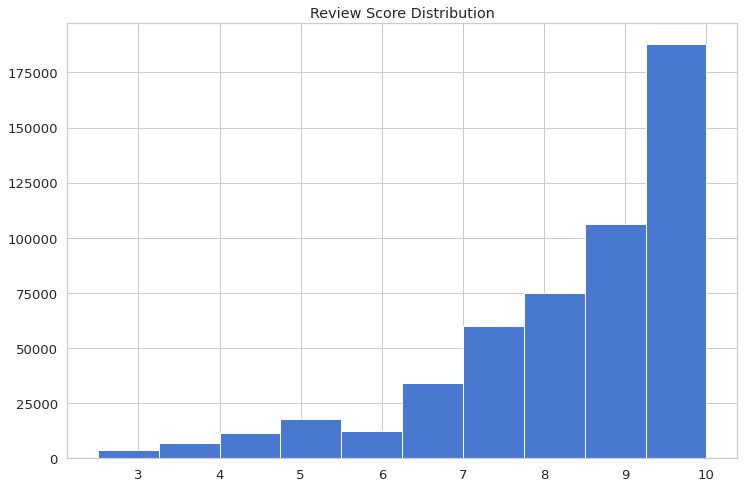

In [ ]:
df_hotel_reviews.Reviewer_Score.hist()
plt.title('Review Score Distribution');

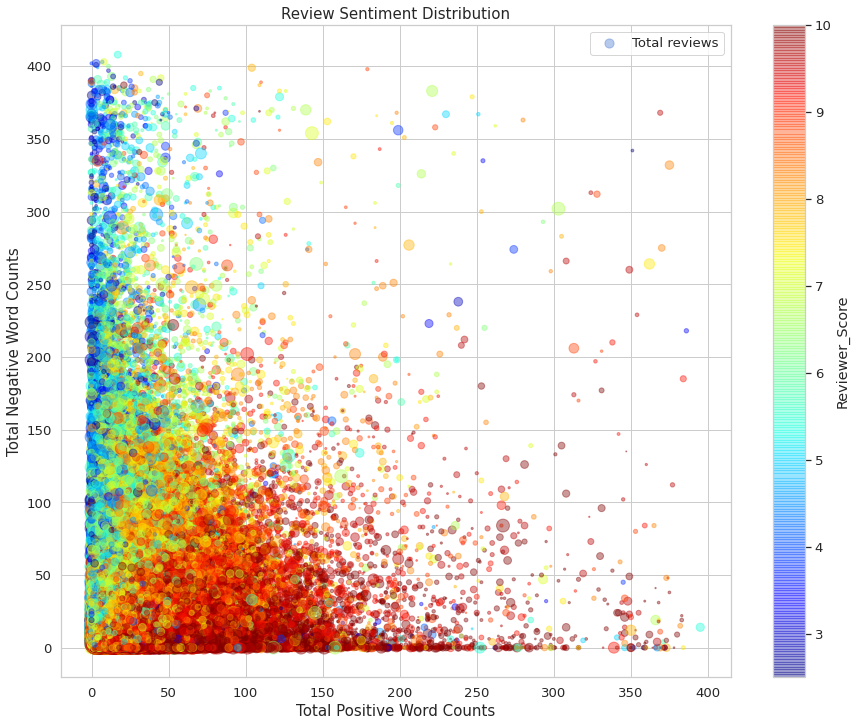

In [ ]:
df_hotel_reviews.plot(kind='scatter', 
                      x='Review_Total_Positive_Word_Counts', 
                      y='Review_Total_Negative_Word_Counts', 
                      label='Total reviews',
             s=df_hotel_reviews.Total_Number_of_Reviews/100,
             c='Reviewer_Score',
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(15,12),
             sharex=False, # label not showing up 
             # https://stackoverflow.com/a/69661993/11105356 
             )
font_size = 15
plt.title("Review Sentiment Distribution",  fontsize=font_size)
plt.xlabel("Total Positive Word Counts", fontsize=font_size)
plt.ylabel("Total Negative Word Counts",  fontsize=font_size)
plt.legend()
plt.show()

In [ ]:
df_hotel_reviews.Reviewer_Nationality.value_counts()[:20]

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
Name: Reviewer_Nationality, dtype: int64

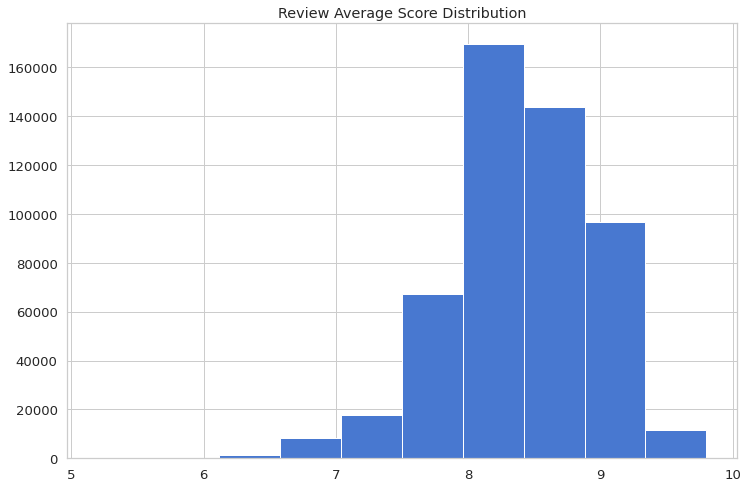

In [ ]:
df_hotel_reviews.Average_Score.hist()
plt.title('Review Average Score Distribution');

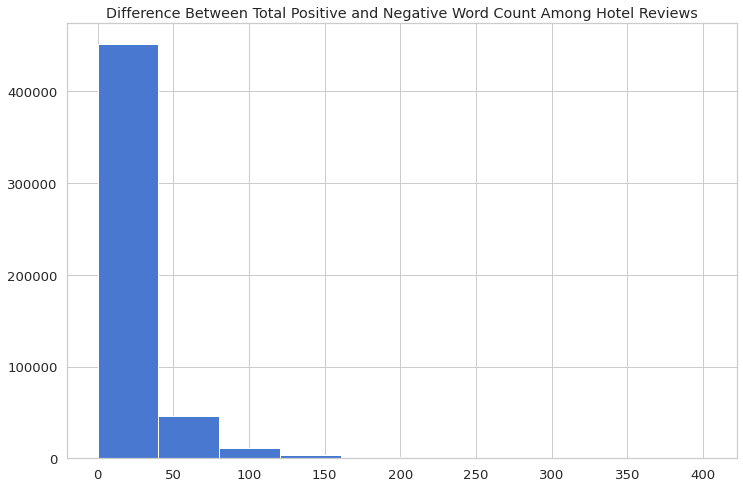

In [ ]:
abs(df_hotel_reviews.Review_Total_Positive_Word_Counts - df_hotel_reviews.Review_Total_Negative_Word_Counts).hist()
plt.title('Difference Between Total Positive and Negative Word Count Among Hotel Reviews');

### Cleaning Review Text

In [ ]:
df_hotel_reviews['Negative_Review'][1]

'No Negative'

In [ ]:
df_hotel_reviews.loc[:, 'Positive_Review'] = df_hotel_reviews.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
df_hotel_reviews.loc[:, 'Negative_Review'] = df_hotel_reviews.Negative_Review.apply(lambda x: x.replace('No Negative', ''))

In [ ]:
df_hotel_reviews['Negative_Review'][1]

''

### Merged Feature (Both Review Text)

In [ ]:
df_hotel_reviews['review'] = df_hotel_reviews.Positive_Review + df_hotel_reviews.Negative_Review

## Set Sentiment Type

In [ ]:
df_hotel_reviews["review_type"] = df_hotel_reviews["Reviewer_Score"].apply(
    lambda x: "bad" if x < 7 else "good")

In [ ]:
df_reviews = df_hotel_reviews[["review", "review_type"]]

In [ ]:
df_reviews

,review,review_type
0,Only the park outside of the hotel was beauti...,bad
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
3,Great location in nice surroundings the bar a...,bad
4,Amazing location and building Romantic settin...,bad
...,...,...
515733,location no trolly or staff to help you take ...,good
515734,Breakfast was ok and we got earlier check in ...,bad
515735,The ac was useless It was a hot week in vienn...,bad
515736,The rooms are enormous and really comfortable...,good


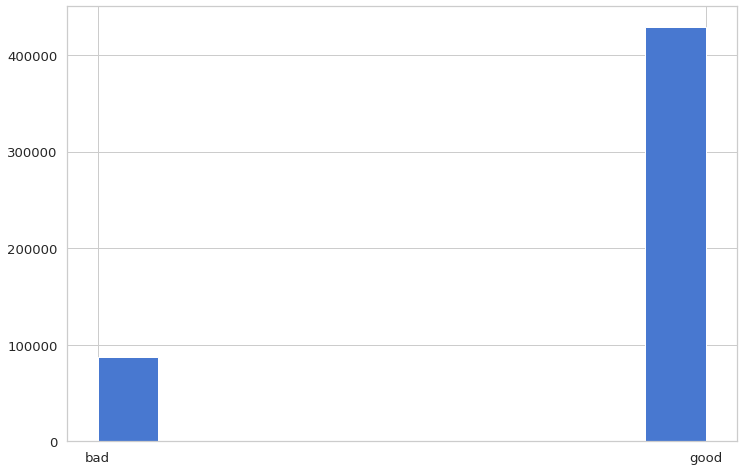

In [ ]:
df_reviews.review_type.hist();
# imbalanced distribution

In [ ]:
df_reviews[df_reviews.review_type == 'good'].review.value_counts()

 Location                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  947
 Everything Nothing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
df_reviews[df_reviews.review_type == 'bad'].review.value_counts()

 Nothing Everything                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
good_reviews = df_reviews[df_reviews.review_type == "good"]
bad_reviews = df_reviews[df_reviews.review_type == "bad"]

In [ ]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

## Word Cloud

In [ ]:
# generate Word Cloud
def gen_wc(txt):
  stopwords = set(STOPWORDS) 

  # crisp wordcloud : https://stackoverflow.com/a/28795577/11105356
  wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords).generate(txt)
  plt.figure(figsize=(14,10))
  plt.imshow(wc, interpolation="bilinear")
  plt.axis('off')
  plt.show()

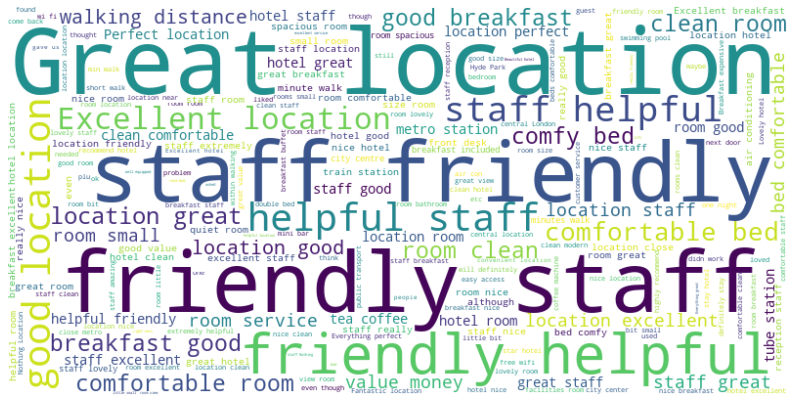

In [ ]:
gen_wc(good_reviews_text)

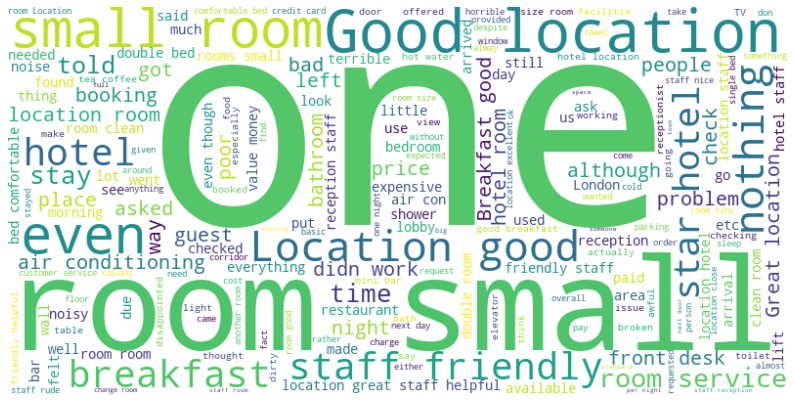

In [ ]:
gen_wc(bad_reviews_text)

## Resample Dataset

Under sample the positive review to achieve a balanced distribution between reviews

In [ ]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)

df_review_resampled = good_df.append(bad_reviews).reset_index(drop=True)
df_review_resampled.shape

(173702, 2)

In [ ]:
df_review_resampled.head()

,review,review_type
0,Location was excellent rooms were extremely c...,good
1,very comfortable bed excellent air con great ...,good
2,The views,good
3,Clean and comfortable room Kettle and selecti...,good
4,Beds comfy staff lovely food amazing room spa...,good


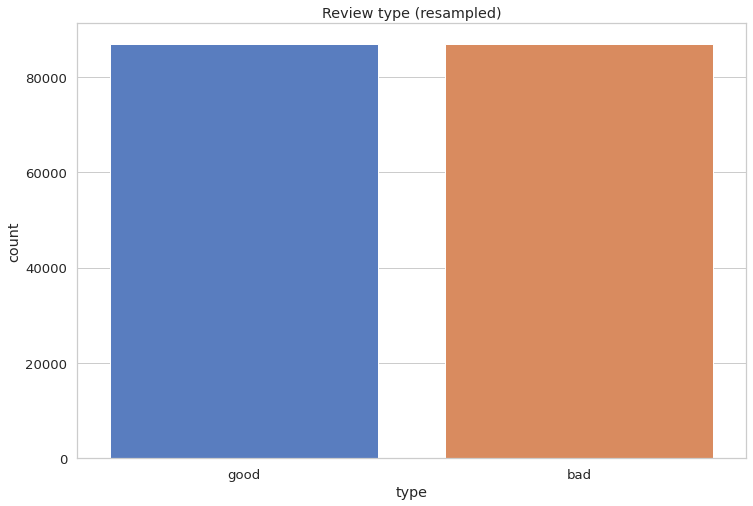

In [ ]:
sns.countplot(
  x='review_type',
  data=df_review_resampled,
  order=df_review_resampled.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

## Data Preparation

### Encoding Labels

In [ ]:
# one_hot_encoder = preprocessing.OneHotEncoder(sparse=False)
# encoded_review = one_hot_encoder.fit_transform(df_review_resampled.review_type.to_numpy().reshape(-1, 1))


label_enc = preprocessing.LabelEncoder()
encoded_review = label_enc.fit_transform(df_review_resampled.review_type.values)

### Train/test Split

In [ ]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_review_resampled.review, 
    encoded_review, 
    test_size=0.25, 
    random_state=RANDOM_SEED
  )

# Modeling

## Feature Engineering

### TF-IDF

In [ ]:
%%time
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(list(train_reviews) + list(test_reviews))

X_train_tfv =  tfv.transform(train_reviews) 
X_test_tfv = tfv.transform(test_reviews)

CPU times: user 32.5 s, sys: 934 ms, total: 33.4 s
Wall time: 36.3 s


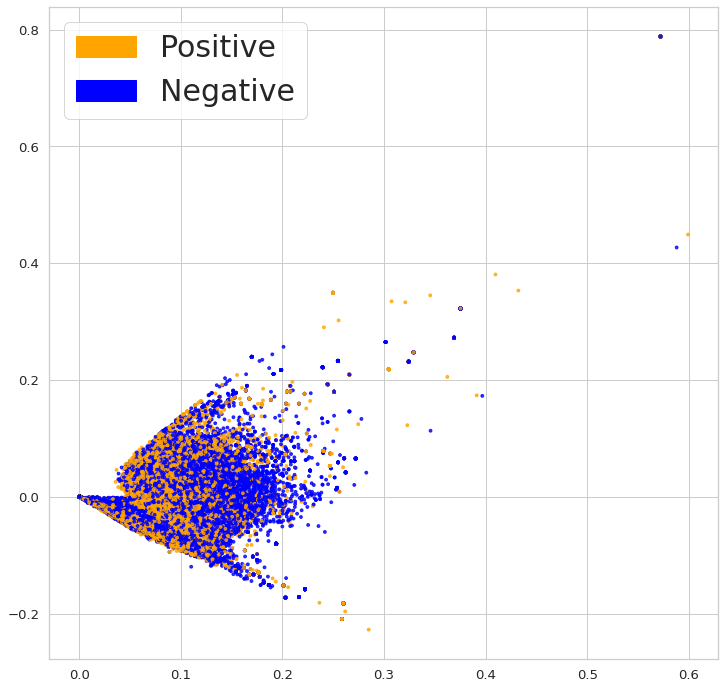

In [ ]:
def plot_LSA(test_data, test_labels):
  lsa = TruncatedSVD(n_components=2)
  lsa.fit(test_data)
  lsa_scores = lsa.transform(test_data)

  colors = ['orange','blue']
  plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
  orange_patch = mpatches.Patch(color='orange', label='Positive')
  blue_patch = mpatches.Patch(color='blue', label='Negative')
  plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(12, 12))          
plot_LSA(X_train_tfv, y_train)
plt.show()

#### Logistic Regression Baseline

In [ ]:
%%time

# issue: https://stackoverflow.com/a/66560912/11105356
clf = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
clf.fit(X_train_tfv, y_train)
predictions = clf.predict_proba(X_test_tfv)

print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")
print (f"ROC AUC: {metrics.roc_auc_score(y_test, predictions[:, 1]):0.3f}")

logloss: 0.403
ROC AUC: 0.900
CPU times: user 20.9 s, sys: 19.5 s, total: 40.4 s
Wall time: 22.8 s


### Count Features

In [ ]:
%%time
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(train_reviews) + list(test_reviews))

X_train_ctv=  ctv.transform(train_reviews) 
X_test_ctv = ctv.transform(test_reviews)

CPU times: user 45.2 s, sys: 811 ms, total: 46 s
Wall time: 47 s


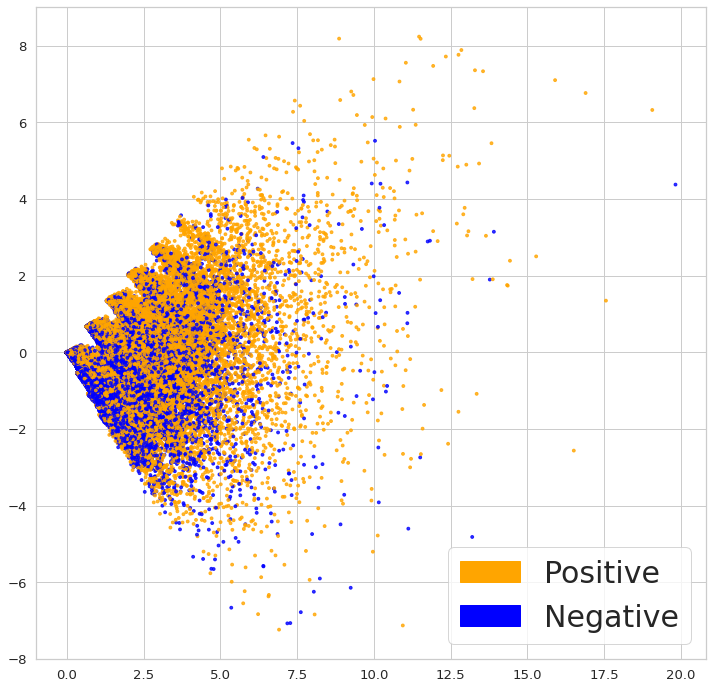

In [ ]:
fig = plt.figure(figsize=(12, 12))          
plot_LSA(X_train_ctv, y_train)
plt.show()

#### Logistic Regression Baseline

In [ ]:
%%time
clf = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
clf.fit(X_train_ctv, y_train)
predictions = clf.predict_proba(X_test_ctv)

print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")
print (f"ROC AUC: {metrics.roc_auc_score(y_test, predictions[:, 1]):0.3f}")

logloss: 0.456
ROC AUC: 0.894
CPU times: user 4min 43s, sys: 1min 48s, total: 6min 32s
Wall time: 4min 16s


## Naive Bayes

In [ ]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfv, y_train)
predictions = clf.predict_proba(X_test_tfv)

print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")
print (f"ROC AUC: {metrics.roc_auc_score(y_test, predictions[:, 1]):0.3f}")

logloss: 0.414
ROC AUC: 0.892
CPU times: user 246 ms, sys: 11.3 ms, total: 257 ms
Wall time: 258 ms


In [ ]:
%%time
clf = MultinomialNB()
clf.fit(X_train_ctv, y_train)
predictions = clf.predict_proba(X_test_ctv)

print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")
print (f"ROC AUC: {metrics.roc_auc_score(y_test, predictions[:, 1]):0.3f}")

logloss: 1.245
ROC AUC: 0.877
CPU times: user 690 ms, sys: 14 ms, total: 704 ms
Wall time: 704 ms


## SVM

In [ ]:
svd = decomposition.TruncatedSVD(n_components=120) # 120-200 is a good range
svd.fit(X_train_tfv)
X_train_svd = svd.transform(X_train_tfv)
X_test_svd = svd.transform(X_test_tfv)

scl = preprocessing.StandardScaler()
scl.fit(X_train_svd)
X_train_svd_scl = scl.transform(X_train_svd)
X_test_svd_scl = scl.transform(X_test_svd)

In [ ]:
%%time

# it never ends :v

clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(X_train_svd_scl, y_train)
predictions = clf.predict_proba(X_test_svd_scl)

print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")
print (f"ROC AUC: {metrics.roc_auc_score(y_test, predictions[:, 1]):0.3f}")

## XGBoost

In [ ]:
%%time
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train_tfv, y_train)
predictions = clf.predict_proba(X_test_tfv)

print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")
print (f"ROC AUC: {metrics.roc_auc_score(y_test, predictions[:, 1]):0.3f}")

logloss: 0.445
ROC AUC: 0.877


## Grid Search

In [ ]:
model_scorer = metrics.make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)

# model_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True, needs_proba=True)



svd = TruncatedSVD()
  
scl = preprocessing.StandardScaler()

# https://stackoverflow.com/a/60868685/11105356

lr_model = LogisticRegression(solver='liblinear')
# Solver lbfgs supports only 'l2' or 'none' penalties
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])


param_grid = {'svd__n_components' : [120, 200],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}


model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=model_scorer,
                                 verbose=10, n_jobs=-1, refit=True, cv=2)

In [ ]:
%%time

model.fit(X_train_tfv, y_train)  # we can use the full data here but im only using xtrain
print(f"Best score: {model.best_score_:0.3f}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best score: -0.436
Best parameters set:
	lr__C: 10
	lr__penalty: 'l1'
	svd__n_components: 200
CPU times: user 1min 56s, sys: 10 s, total: 2min 6s
Wall time: 16min 9s


## Word Vectors
### Universal Sentence Encoder from TF-HUB

In [ ]:
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 130276/130276 [1:20:09<00:00, 27.09it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 43426/43426 [24:45<00:00, 29.22it/s]


In [ ]:
print(X_train.shape, X_test.shape)

(130276, 512) (43426, 512)


In [ ]:
print(y_train.shape, y_test.shape)

(130276,) (43426,)


# Deep Learning Modeling

## Utility Function

In [ ]:
# plot accuracy and loss
def plot_history(history):
  accuracy = history.history['accuracy']
  val_accuracy= history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

# plot model architecture
def plot_model(model):
  model.summary()
  return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

## Baseline NN Model

In [ ]:
def build_model_1():
  model = Sequential()
  model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.001))
  return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 164,353
Trainable params: 164,353
Non-trainable params: 0
_________________________________________________________________


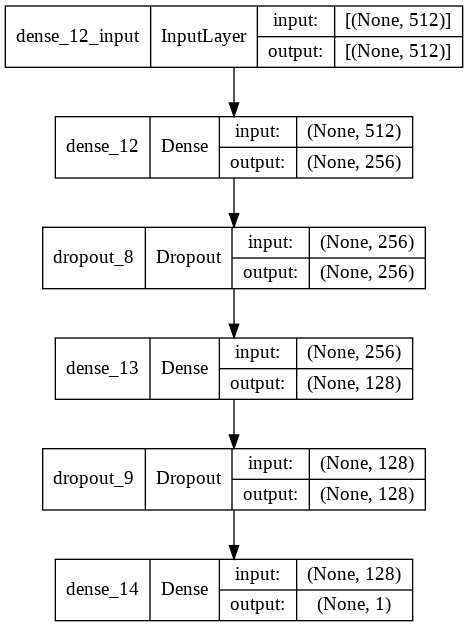

In [ ]:
model_1 = build_model_1()
plot_model(model_1)

In [ ]:
history = model_1.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7328/7328 [==============================] - 25s 3ms/step - loss: 0.4294 - accuracy: 0.7962 - val_loss: 0.4152 - val_accuracy: 0.8094
Epoch 2/10
7328/7328 [==============================] - 24s 3ms/step - loss: 0.4067 - accuracy: 0.8106 - val_loss: 0.4046 - val_accuracy: 0.8119
Epoch 3/10
7328/7328 [==============================] - 24s 3ms/step - loss: 0.3934 - accuracy: 0.8187 - val_loss: 0.3981 - val_accuracy: 0.8136
Epoch 4/10
7328/7328 [==============================] - 25s 3ms/step - loss: 0.3814 - accuracy: 0.8266 - val_loss: 0.3983 - val_accuracy: 0.8169
Epoch 5/10
7328/7328 [==============================] - 24s 3ms/step - loss: 0.3692 - accuracy: 0.8329 - val_loss: 0.3981 - val_accuracy: 0.8164
Epoch 6/10
7328/7328 [==============================] - 25s 3ms/step - loss: 0.3570 - accuracy: 0.8376 - val_loss: 0.3998 - val_accuracy: 0.8137
Epoch 7/10
7328/7328 [==============================] - 25s 3ms/step - loss: 0.3453 - accuracy: 0.8433 - val_loss: 0.3995 - val_ac

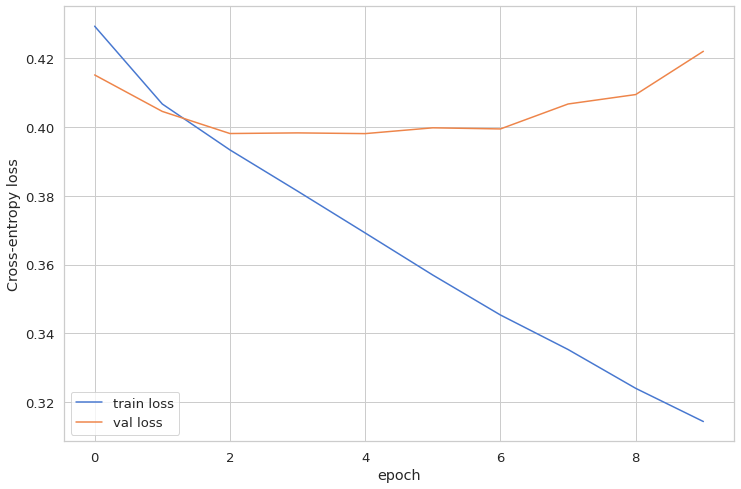

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

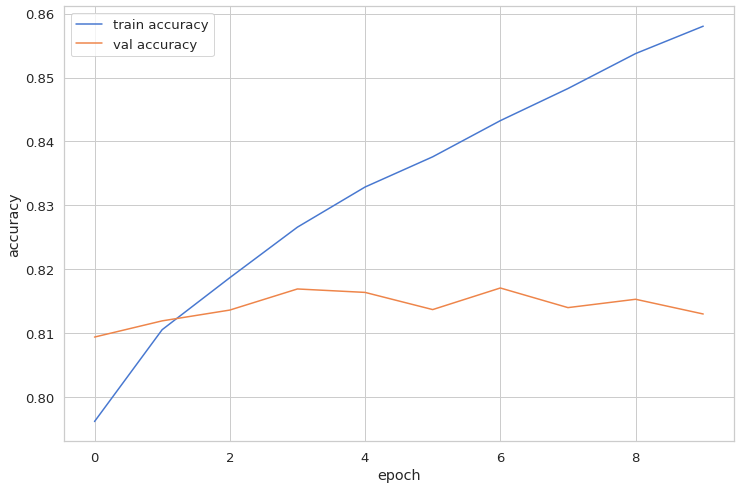

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model_1.evaluate(X_test, y_test)

1358/1358 [==============================] - 4s 3ms/step - loss: 0.4416 - accuracy: 0.8087


[0.4416257441043854, 0.8087320923805237]

### Prediction

In [ ]:
# predict_classes() was removed in tf 2.6+, predict_proba(): use predict()
# https://keras.rstudio.com/reference/predict_proba.html#details

# 
# https://github.com/keras-team/keras/blob/f0eb8d538c82798944346b4b2df917a06bf5e9d4/keras/engine/sequential.py#L254

y_pred_probas = model_1.predict(X_test) 
y_pred_classes = (y_preds > 0.5).astype('int32')

In [ ]:
print(test_reviews.iloc[0])
print("Bad" if y_pred_classes[0] == 0 else "Good", y_pred_probas[0])

 Location staff  Asked for late checkout and didnt get an answer then got a yes but had to pay 25 euros by noon they called to say sorry you have to leave in 1h knowing that i had a sick dog and an appointment next to the hotel 
Bad [0.03418516]


In [ ]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5] == 0 else "Good")

 Easy to find Easy location No traffic noise in room  Flooded bathroom from room above Painting and decorating blocking stair access 
Bad


In [ ]:
print(y_pred_probas[5])
"Bad" if  y_pred_classes[5] == 0 else "Good"

[0.53020537]


'Good'

## LSTM Model

In [ ]:
y_train.shape

(130276,)

For an LSTM layer, you need the shape like  `(NumberOfExamples, TimeSteps, FeaturesPerStep)`

In [ ]:
X_train_reshaped = X_train[:, newaxis,:]
X_test_reshaped = X_test[:, newaxis,:]
y_train_reshaped = y_train[:, newaxis, newaxis]
y_test_reshaped = y_test[:, newaxis, newaxis]

In [ ]:
y_train_reshaped.shape

(130276, 1, 1)

In [ ]:
1,X_train_reshaped.shape[2]

(1, 512)

In [ ]:
def build_model_lstm():
  model = Sequential()
  model.add(LSTM(256, activation='sigmoid', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))

  model.add(Dense(128, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
  return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 256)            787456    
                                                                 
 dense_17 (Dense)            (None, 1, 128)            32896     
                                                                 
 dense_18 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 820,481
Trainable params: 820,481
Non-trainable params: 0
_________________________________________________________________


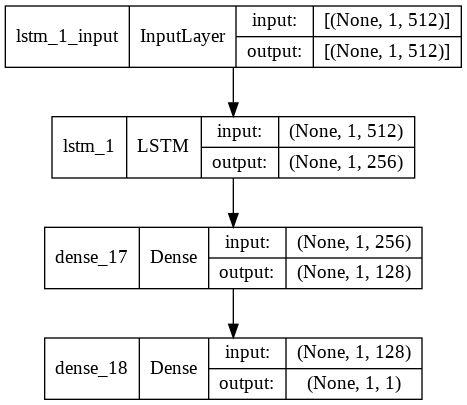

In [ ]:
model_lstm_1 = build_model_lstm()
plot_model(model_lstm_1)

In [ ]:
%%time

history_lstm_1 = model_lstm_1.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7328/7328 [==============================] - 39s 5ms/step - loss: 0.4505 - accuracy: 0.7843 - val_loss: 0.4279 - val_accuracy: 0.7984
Epoch 2/10
7328/7328 [==============================] - 36s 5ms/step - loss: 0.4241 - accuracy: 0.7980 - val_loss: 0.4224 - val_accuracy: 0.7999
Epoch 3/10
7328/7328 [==============================] - 38s 5ms/step - loss: 0.4176 - accuracy: 0.8010 - val_loss: 0.4224 - val_accuracy: 0.7997
Epoch 4/10
7328/7328 [==============================] - 36s 5ms/step - loss: 0.4149 - accuracy: 0.8032 - val_loss: 0.4166 - val_accuracy: 0.8025
Epoch 5/10
7328/7328 [==============================] - 36s 5ms/step - loss: 0.4120 - accuracy: 0.8049 - val_loss: 0.4130 - val_accuracy: 0.8027
Epoch 6/10
7328/7328 [==============================] - 36s 5ms/step - loss: 0.4104 - accuracy: 0.8061 - val_loss: 0.4128 - val_accuracy: 0.8052
Epoch 7/10
7328/7328 [==============================] - 36s 5ms/step - loss: 0.4090 - accuracy: 0.8062 - val_loss: 0.4138 - val_ac

In [ ]:
model_lstm_1.evaluate(X_test_reshaped, y_test_reshaped)

1358/1358 [==============================] - 6s 4ms/step - loss: 0.4133 - accuracy: 0.8032


[0.41327717900276184, 0.8031824231147766]

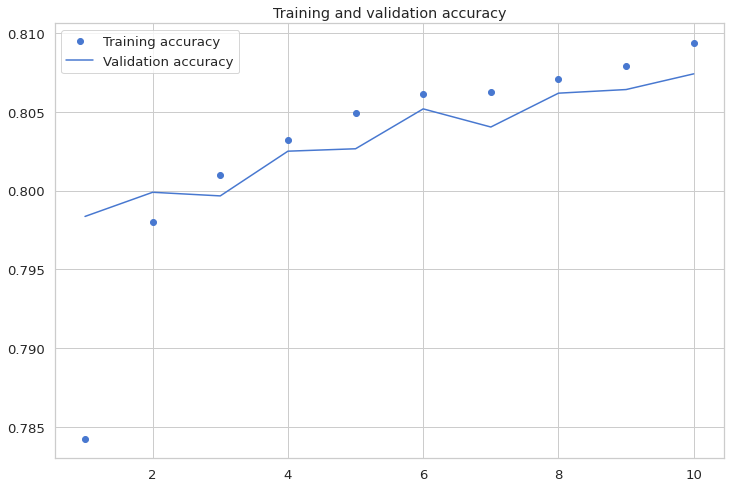

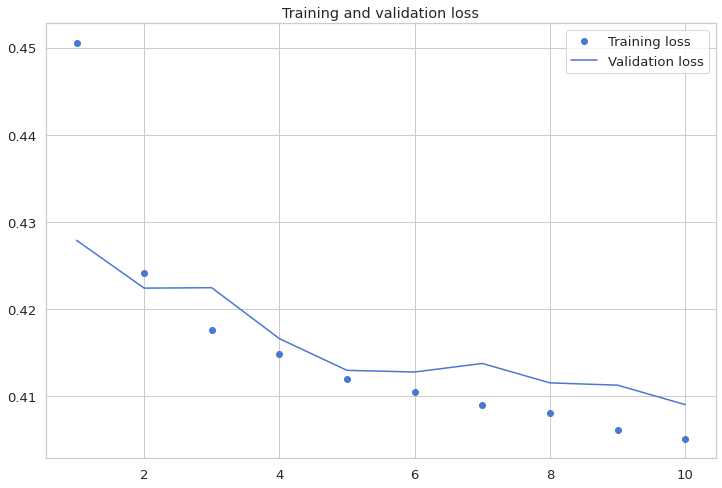

In [ ]:
plot_history(history_lstm_1)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

def build_model_lstm_2():
  model = Sequential()

  model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
  model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))

  model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
  return model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_3 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_19 (Dense)            (None, 1, 1)              65        
                                                                 
Total params: 1,034,049
Trainable params: 1,034,049
Non-trainable params: 0
_________________________________________________________________


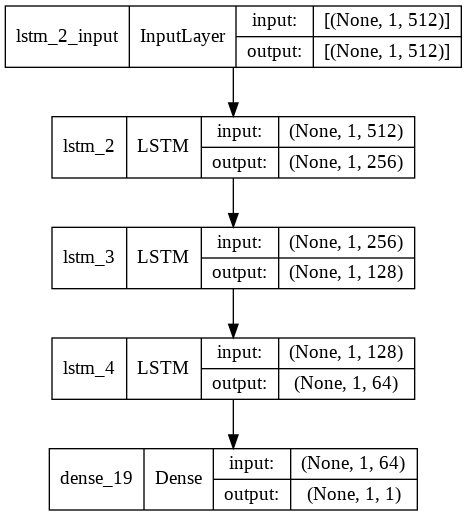

In [ ]:
model_lstm_2 = build_model_lstm_2()
plot_model(model_lstm_2)

In [ ]:
%%time
history = model_lstm_2.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7328/7328 [==============================] - 70s 9ms/step - loss: 0.4332 - accuracy: 0.7931 - val_loss: 0.4158 - val_accuracy: 0.8033
Epoch 2/10
7328/7328 [==============================] - 67s 9ms/step - loss: 0.4074 - accuracy: 0.8104 - val_loss: 0.4057 - val_accuracy: 0.8103
Epoch 3/10
7328/7328 [==============================] - 69s 9ms/step - loss: 0.3947 - accuracy: 0.8177 - val_loss: 0.4025 - val_accuracy: 0.8143
Epoch 4/10
7328/7328 [==============================] - 69s 9ms/step - loss: 0.3847 - accuracy: 0.8243 - val_loss: 0.3970 - val_accuracy: 0.8173
Epoch 5/10
7328/7328 [==============================] - 67s 9ms/step - loss: 0.3742 - accuracy: 0.8295 - val_loss: 0.3952 - val_accuracy: 0.8162
Epoch 6/10
7328/7328 [==============================] - 69s 9ms/step - loss: 0.3635 - accuracy: 0.8354 - val_loss: 0.3976 - val_accuracy: 0.8123
Epoch 7/10
7328/7328 [==============================] - 69s 9ms/step - loss: 0.3533 - accuracy: 0.8407 - val_loss: 0.3973 - val_ac

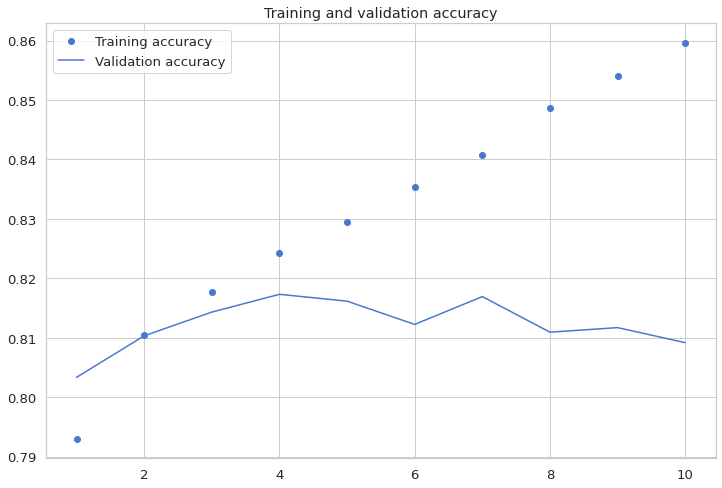

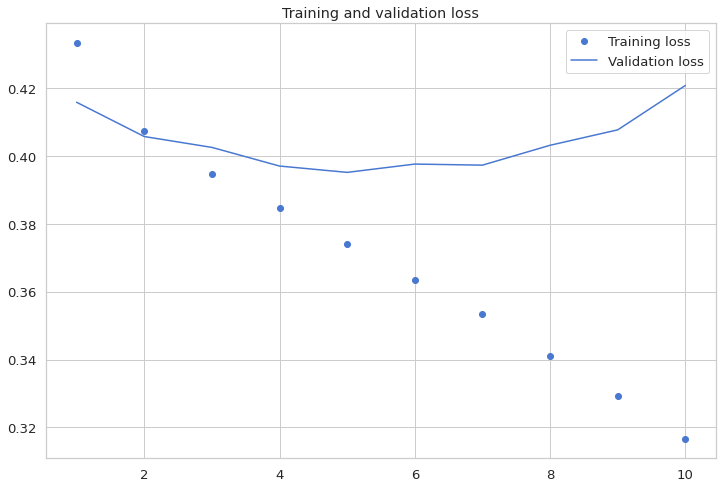

In [ ]:
plot_history(history)

In [ ]:
model_lstm_2.evaluate(X_test_reshaped, y_test_reshaped)

1358/1358 [==============================] - 6s 4ms/step - loss: 0.4273 - accuracy: 0.8091


[0.4273212254047394, 0.8090775012969971]

## Serve Model

### Save Model

In [ ]:
model_lstm_2.save("lstm_sentiment_model.h5")

### Load Model

In [ ]:
imported_model = tf.keras.models.load_model('/content/lstm_final_model.h5')
imported_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_3 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_19 (Dense)            (None, 1, 1)              65        
                                                                 
Total params: 1,034,049
Trainable params: 1,034,049
Non-trainable params: 0
_________________________________________________________________


### Prediction

#### Positive Sentiment

In [ ]:
text = 'This room is great'
emb_test = use(text)
emb_test.shape

TensorShape([1, 512])

In [ ]:
emb_test_reshaped = emb_test[:, newaxis, :]
emb_test_reshaped.shape

TensorShape([1, 1, 512])

In [ ]:
imported_model.predict(emb_test_reshaped)

array([[[0.7893306]]], dtype=float32)

In [ ]:
(imported_model.predict(emb_test_reshaped)[0][0][0] > 0.5).astype('int32')

1

In [ ]:
sentiment_val = (imported_model.predict(emb_test_reshaped) > 0.5).astype('int32')

"Good" if sentiment_val == 1 else "Bad"

'Good'

#### Negative Sentiment

In [ ]:
text = 'This room is small'
emb_test = use(text)

emb_test_reshaped = emb_test[:, newaxis, :]
emb_test_reshaped.shape

imported_model.predict(emb_test_reshaped)

array([[[0.27476135]]], dtype=float32)

In [ ]:
sentimen_val = (imported_model.predict(emb_test_reshaped) > 0.5).astype('int32')

"Good" if sentimen_val == 1 else "Bad"

'Bad'

### Prediction Pipeline

In [ ]:
def predict_sentiment(txt):
  emb_txt = use(txt)
  emb_test_reshaped = emb_txt[:, newaxis, :]
  sentiment_val = (imported_model.predict(emb_test_reshaped) > 0.5).astype('int32')
  print("Score:", imported_model.predict(emb_test_reshaped).flatten()[0])
  return "Positive" if sentiment_val == 1 else "Negative"

In [ ]:
sample_text = "I love the room service"
f"The sentiment of this sentence is : {predict_sentiment(sample_text)}"

Score: 0.8424862


'The sentiment of this sentence is : Positive'

In [ ]:
sample_text = "I like the room service but the bathroom is small"
f"The sentiment of this sentence is : {predict_sentiment(sample_text)}"

Score: 0.61470836


'The sentiment of this sentence is : Positive'

In [ ]:
sample_text = "The windows is so big. it has good air circulation"
f"The sentiment of this sentence is : {predict_sentiment(sample_text)}"

Score: 0.9178533


'The sentiment of this sentence is : Positive'

In [ ]:
sample_text = "The windows is so small. it has bad air circulation"
f"The sentiment of this sentence is : {predict_sentiment(sample_text)}"

Score: 0.1390446


'The sentiment of this sentence is : Negative'

# Conclusion
- LSTM performs comparatively better than baseline fully connected dense model
- In order to achieve a balanced distribution between positive and negative reviews, the positive reviews are down sampled, hence discarding lots of valuable information
- More resampling technique such as stratifying, Synthetic oversampling such as SMOTE, NLP augmentation like [nlpaug](https://github.com/makcedward/nlpaug) options will be explored